<a href="https://colab.research.google.com/github/SACHZZ/HodgeLaplacian/blob/main/Analyse_FP.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
from google.colab import drive
import os
drive.mount("/content/drive")

path="/content/drive/My Drive/Colab Notebooks/TDA/NTU_Projects/Hodge_Laplacian"
os.chdir(path)

Mounted at /content/drive


In [2]:
!pip install GeneralisedFormanRicci
!pip install gudhi
!pip install plotly

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 29.3 MB 1.3 MB/s 
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [3]:
import functools
import pandas as pd
import numpy as np 
import gudhi as gd
import networkx as nx
import plotly.graph_objects as go
import math
import matplotlib as mpl
import matplotlib
import plotly.io as pio
import matplotlib.pyplot as plt
from GeneralisedFormanRicci.frc import gen_graph
from scipy.sparse import *
from scipy import *

In [4]:
def faces(simplices):
    faceset = set()
    for simplex in simplices:
        numnodes = len(simplex)
        for r in range(numnodes, 0, -1):
            for face in combinations(simplex, r):
                faceset.add(tuple(sorted(face)))
    return faceset

def n_faces(face_set, n):
    return filter(lambda face: len(face)==n+1, face_set)

def boundary_operator(face_set, i):
    source_simplices = list(n_faces(face_set, i))
    target_simplices = list(n_faces(face_set, i-1))
    #print(source_simplices, target_simplices)

    if len(target_simplices)==0:
        S = dok_matrix((1, len(source_simplices)), dtype=np.float64)
        S[0, 0:len(source_simplices)] = 1
    else:
        source_simplices_dict = {source_simplices[j]: j for j in range(len(source_simplices))}
        target_simplices_dict = {target_simplices[i]: i for i in range(len(target_simplices))}

        S = dok_matrix((len(target_simplices), len(source_simplices)), dtype=np.float64)
        for source_simplex in source_simplices:
            for a in range(len(source_simplex)):
                target_simplex = source_simplex[:a]+source_simplex[(a+1):]
                i = target_simplices_dict[target_simplex]
                j = source_simplices_dict[source_simplex]
                S[i, j] = -1 if a % 2==1 else 1
    
    return S

In [17]:
filename = '120.xyz'

beta0 = []
beta1 = []
mean0 = []
mean1 = []
std0 = []
std1 = []
mini0 = []
mini1 = []
maxi0 = []
maxi1 = []
Lap_graph_energy_0 = []
Lap_graph_energy_1 = []
GA_graph_energy_0 = []
GA_graph_energy_1 = []
SM_2_0 = []
SM_2_1 = []
QWI0 = []
QWI1 = []
STN0 = []
STN1 = []

atoms = []
coords = []
xyz = open(filename)

n_atoms = int(xyz.readline())
title = xyz.readline()
for line in xyz:
    atom,x,y,z = line.split()
    atoms.append(atom)
    coords.append([float(x), float(y), float(z)])
xyz.close()

In [18]:
for f in np.round(np.arange(0,10,0.2),1):
    rc = gd.RipsComplex(coords, max_edge_length=f)
    simplex_tree = rc.create_simplex_tree(max_dimension=2)
    val = simplex_tree.get_filtration()
    simplices = set()
    for v in val:
        simplices.add(tuple(v[0]))
    
    laplacian_0 = np.matmul(boundary_operator(simplices, 1).toarray(), np.transpose(boundary_operator(simplices, 1).toarray()))
    laplacian_1 = np.matmul(boundary_operator(simplices, 2).toarray(), np.transpose(boundary_operator(simplices, 2).toarray())) + np.matmul(np.transpose(boundary_operator(simplices, 1).toarray()), boundary_operator(simplices, 1).toarray())
    
    # Attributes for Laplacian Dim(0) for each filtration value
    eigval_0, eigvec_0 = np.linalg.eigh(laplacian_0)
    eigval_0 = [0 if i <1e-3 else i for i in eigval_0]
    b_0 = [j for j in eigval_0 if j==0]
    b_0_positive = [j for j in eigval_0 if j>0]  
    b_0_positive_rp = np.reciprocal(b_0_positive)
    A_0 = len(b_0_positive)
    ab_std_0 = np.absolute(eigval_0-np.average(eigval_0))
    
    beta_0 = len(b_0) #Attribute1
    mean_0 = np.average(eigval_0) #Attribute2
    std_0 = np.std(eigval_0) #Attribute3
    sum_0 = np.sum(eigval_0) #Attribute4
    min_0 = 0 if np.shape(b_0_positive)==(0,) else np.min(b_0_positive) #Attribute5 np.min(b_0_positive_formin)
    max_0 = np.max(eigval_0) #Attribute6
    ab_std_sum_0 = np.sum(ab_std_0) #Attribute7
    order_2_sum_0 = np.sum(np.square(eigval_0)) #Attribute8
    qwi_0 = np.sum(np.multiply(b_0_positive_rp,(A_0+1))) #Attribute9
    #stn_0 = np.log(np.multiply(np.prod(b_0_positive),1/(A_0+1))) #Attribute10 This gives inf values
    stn_0 = np.sum(np.log(b_0_positive)) - np.log(A_0+1) #Attribute10

        
    # Attributes for Laplacian Dim(1) for each filtration value
    eigval_1, eigvec_1 = np.linalg.eigh(laplacian_1)
    eigval_1 = [0 if i <1e-3 else i for i in eigval_1]
    b_1 = [j for j in eigval_1 if j==0]
    b_1_positive = [j for j in eigval_1 if j>0]
    b_1_positive_rp = np.reciprocal(b_1_positive)
    A_1 = len(b_1_positive)
    ab_std_1 = np.absolute(eigval_1-np.average(eigval_1))

    beta_1 = len(b_1) #Attribute1
    mean_1 = 0 if np.shape(laplacian_1)==(0,0) else np.average(eigval_1) #Attribute2
    std_1 = 0 if np.shape(laplacian_1)==(0,0) else np.std(eigval_1) #Attribute3
    sum_1 = 0 if np.shape(laplacian_1)==(0,0) else np.sum(eigval_1) #Attribute4
    min_1 = 0 if np.shape(laplacian_1)==(0,0) else np.min(eigval_1) #Attribute5
    max_1 = 0 if np.shape(laplacian_1)==(0,0) else np.max(eigval_1) #Attribute6
    ab_std_sum_1 = np.sum(ab_std_1) #Attribute7
    order_2_sum_1 = np.sum(np.square(eigval_1)) #Attribute8
    qwi_1 = np.sum(np.multiply(b_1_positive_rp,(A_1+1))) #Attribute9
    #stn_1 = np.log(np.multiply(np.prod(b_1_positive),1/(A_1+1))) #Attribute10 This gives inf values
    stn_1 = np.sum(np.log(b_1_positive)) - np.log(A_1+1) #Attribute10
        
        
    beta0.append(beta_0)
    beta1.append(beta_1)
    mean0.append(mean_0)
    mean1.append(mean_1)
    std0.append(std_0)
    std1.append(std_1)
    mini0.append(min_0)
    mini1.append(min_1)
    maxi0.append(max_0)
    maxi1.append(max_1)
    Lap_graph_energy_0.append(sum_0)
    Lap_graph_energy_1.append(sum_1)
    GA_graph_energy_0.append(ab_std_sum_0)
    GA_graph_energy_1.append(ab_std_sum_1)
    SM_2_0.append(order_2_sum_0)
    SM_2_1.append(order_2_sum_1)
    QWI0.append(qwi_0)
    QWI1.append(qwi_1)
    STN0.append(stn_0)
    STN1.append(stn_1)    
             

/usr/local/lib/python3.7/dist-packages/numpy/lib/function_base.py:380: RuntimeWarning: Mean of empty slice.
  avg = a.mean(axis)
/usr/local/lib/python3.7/dist-packages/numpy/core/_methods.py:189: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


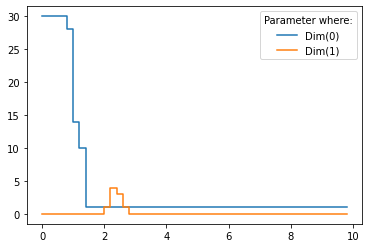

In [19]:
attribute_0 = beta0
attribute_1 = beta1
X = np.arange(0,10,0.2)
Y0 = np.array(attribute_0)
Y1 = np.array(attribute_1)
plt.step(X, Y0, label='Dim(0)')
plt.step(X, Y1, label='Dim(1)')
plt.legend(title='Parameter where:')
plt.show()

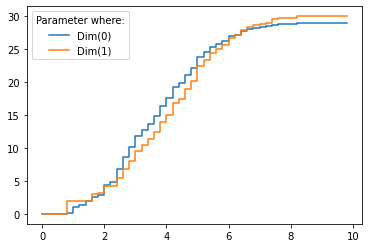

In [20]:
attribute_0 = mean0
attribute_1 = mean1
#X = np.arange(0,13,0.5)
Y0 = np.array(attribute_0)
Y1 = np.array(attribute_1)
plt.step(X, Y0, label='Dim(0)')
plt.step(X, Y1, label='Dim(1)')
plt.legend(title='Parameter where:')
plt.show()

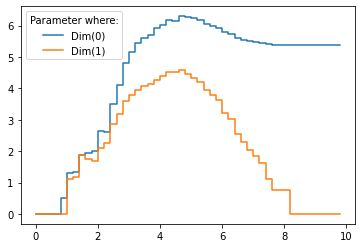

In [21]:
attribute_0 = std0
attribute_1 = std1
#X = np.arange(0,13,0.5)
Y0 = np.array(attribute_0)
Y1 = np.array(attribute_1)
plt.step(X, Y0, label='Dim(0)')
plt.step(X, Y1, label='Dim(1)')
plt.legend(title='Parameter where:')
plt.show()

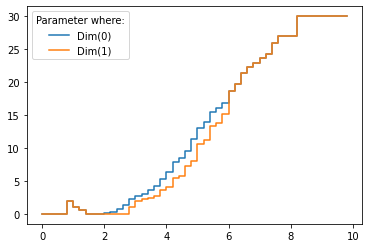

In [22]:
attribute_0 = mini0
attribute_1 = mini1
#X = np.arange(0,13,0.5)
Y0 = np.array(attribute_0)
Y1 = np.array(attribute_1)
plt.step(X, Y0, label='Dim(0)')
plt.step(X, Y1, label='Dim(1)')
plt.legend(title='Parameter where:')
plt.show()

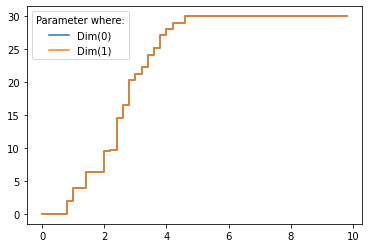

In [23]:
attribute_0 = maxi0
attribute_1 = maxi1
#X = np.arange(0,13,0.5)
Y0 = np.array(attribute_0)
Y1 = np.array(attribute_1)
plt.step(X, Y0, label='Dim(0)')
plt.step(X, Y1, label='Dim(1)')
plt.legend(title='Parameter where:')
plt.show()

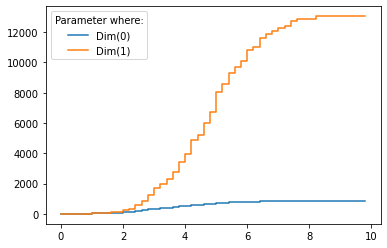

In [24]:
attribute_0 = Lap_graph_energy_0
attribute_1 = Lap_graph_energy_1
#X = np.arange(0,13,0.5)
Y0 = np.array(attribute_0)
Y1 = np.array(attribute_1)
plt.step(X, Y0, label='Dim(0)')
plt.step(X, Y1, label='Dim(1)')
plt.legend(title='Parameter where:')
plt.show()

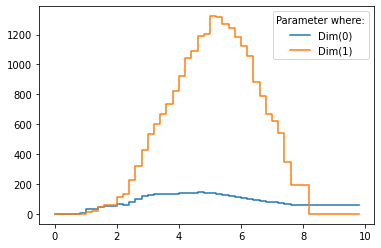

In [25]:
attribute_0 = GA_graph_energy_0
attribute_1 = GA_graph_energy_1
#X = np.arange(0,13,0.5)
Y0 = np.array(attribute_0)
Y1 = np.array(attribute_1)
plt.step(X, Y0, label='Dim(0)')
plt.step(X, Y1, label='Dim(1)')
plt.legend(title='Parameter where:')
plt.show()

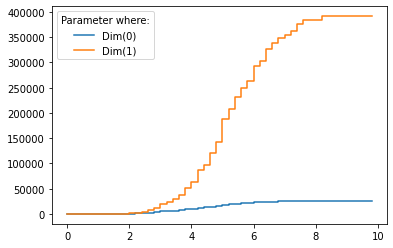

In [26]:
attribute_0 = SM_2_0
attribute_1 = SM_2_1
#X = np.arange(0,13,0.5)
Y0 = np.array(attribute_0)
Y1 = np.array(attribute_1)
plt.step(X, Y0, label='Dim(0)')
plt.step(X, Y1, label='Dim(1)')
plt.legend(title='Parameter where:')
plt.show()

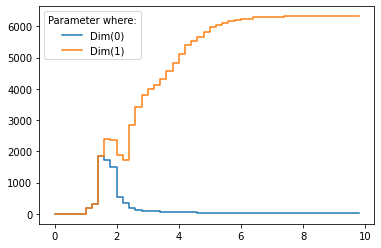

In [27]:
attribute_0 = QWI0
attribute_1 = QWI1
#X = np.arange(0,13,0.5)
Y0 = np.array(attribute_0)
Y1 = np.array(attribute_1)
plt.step(X, Y0, label='Dim(0)')
plt.step(X, Y1, label='Dim(1)')
plt.legend(title='Parameter where:')
plt.show()

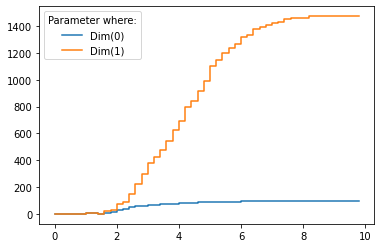

In [28]:
attribute_0 = STN0
attribute_1 = STN1
#X = np.arange(0,13,0.5)
Y0 = np.array(attribute_0)
Y1 = np.array(attribute_1)
plt.step(X, Y0, label='Dim(0)')
plt.step(X, Y1, label='Dim(1)')
plt.legend(title='Parameter where:')
plt.show()